# Coaddition and Subtraction

Version 0.2

By Yusra AlSayyad (Princeton University)

This notebook provides some problems for ground-based coaddition and subtraction.

We add and subtract images for different purposes: addition to get the benefits of longer exposures and subtraction to reveal what has changed.  However, in order to perform either operation, the following  image characteristics need to be normalized:
* Astrometric calibration (i.e. WCS)
* Photometric calibration (i.e. Zeropoint)
* Background level
* Point Spread Function (PSF) (optional for coaddition)

For these problems, we'll assume that we have images that have already been normalized for WCS, zeropoint, and background variations.

### Problem 1) Expected depth of a coadd

In order of magnitude calculations, you may hear people throw around the statement that the depth of a coadd increases by a factor of $\sqrt{N}$  for N single-epoch images. Where does this come from? Under what conditions is this a good approximation?

We are going to use our same star + noise 1-D simulation from  `IntroductionToBasicStellarPhotometry.ipynb` and `FindingSources.ipynb`:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MultipleLocator
from scipy.stats import norm

In [2]:
def pixel_plot(pix, counts, fig=None, ax=None): 
    '''Make a pixelated 1D plot'''
    if fig is None and ax is None:
        fig, ax = plt.subplots()
    
    ax.step(pix, counts, 
            where='post')
    
    ax.set_xlabel('pixel number')
    ax.set_ylabel('relative counts')
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.xaxis.set_major_locator(MultipleLocator(5))
    fig.tight_layout()
    return fig, ax

# It is sufficient to copy and paste from
# your introductionToBasicStellarPhotometry noteboook

def phi(x, mu, fwhm):
    """Evalute the 1d PSF N(mu, sigma^2) along x
    
    Parameters
    ----------
    x : array-like of shape (n_pixels,)
        detector pixel number
    mu : float
        mean position of the 1D star
    fwhm : float
        Full-width half-maximum of the stellar profile on the detector
    
    Returns
    -------
    flux : array-like of shape (n_pixels,)
        Flux in each pixel of the input array
    """
    sigma = fwhm/2.3548
    flux = 1/(sigma * (2*np.pi)**0.5) * np.exp(-(0.5 * ((x- mu)/sigma )**2))

    return flux


# Define your image simulation function to
# It is sufficient to copy and paste from
# your introductionToBasicStellarPhotometry noteboook
# Note that the background S should now be supplied as 
# an array of length (x) or a constant. 

def simulate(x, mu, fwhm, S, F):
    """simulate a noisy stellar signal
    
    Parameters
    ----------
    x : array-like
        detector pixel number
    mu : float
        mean position of the 1D star
    fwhm : float
        Full-width half-maximum of the stellar profile on the detector
    S : float or array-like of len(x)
        Sky background for each pixel
    F : float
        Total stellar flux
    
    Returns
    -------
    noisy_counts : array-like (same shape as x)
        the (noisy) number of counts in each pixel
    """
    flux = phi(x, mu, fwhm)
    signal = flux*F + S
    signal_plus_noise = signal + np.random.normal(signal, np.sqrt(signal))
    
    noisy_counts = signal_plus_noise - flux*F

    return noisy_counts

### Problem 1.1) Make a simple mean coadd

Simulate N observations of a star, and coadd them by taking the mean of the N observations. (We can only do this because they are already astrometrically and photometrically aligned and have the same background value.)

(<Figure size 432x288 with 1 Axes>,
 <Axes: xlabel='pixel number', ylabel='relative counts'>)

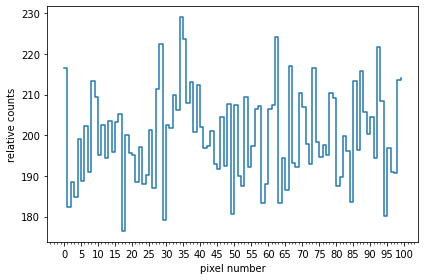

In [4]:
MU = 35
S = 100
F = 100
FWHM = 5

x = np.arange(100)

# simulate a single observation of the star and plot:
y = simulate(x, MU, FWHM, S, F)
pixel_plot(x, y)

In [10]:
# Write a simulateN function that returns an array of size (N, x)
# representing N realizations of your simulated star
# This will stand in as a stack of multiple observations of one star

def simulateN(x, mu, fwhm, S, F, N):
    """simulate a noisy stellar signal
    
    Parameters
    ----------
    x : array-like
        detector pixel number
    mu : float
        mean position of the 1D star
    fwhm : float
        Full-width half-maximum of the stellar profile on the detector
    S : float or array-like of len(x)
        Sky background for each pixel
    F : float
        Total stellar flux
    N: int
        Number of images to simulate
        
    Returns
    -------
    noisy_counts : array-like of shape (N, x)
        the (noisy) number of counts in each pixel
    """
    noisy_counts_arr = []
    for i in range(N):
    
        flux = phi(x, mu, fwhm)
        signal = flux*F + S
        signal_plus_noise = signal + np.random.normal(signal, np.sqrt(signal))
    
        noisy_counts = signal_plus_noise - flux*F
        noisy_counts_arr.append(noisy_counts)
    noisy_counts_arr = np.array(noisy_counts_arr)
    return noisy_counts_arr


(50, 100)
100


(<Figure size 432x288 with 1 Axes>,
 <Axes: xlabel='pixel number', ylabel='relative counts'>)

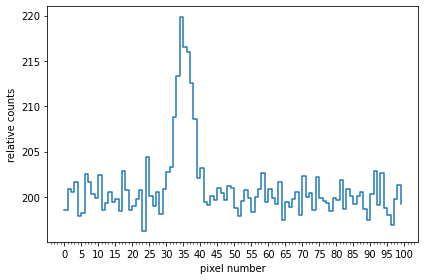

In [62]:
# simulate N=50 images with the same star
x = np.arange(100)
N = 50
stack = simulateN(x, MU, FWHM, S, F, N)
print(stack.shape)

# where stack is an array of size (50, 100) representing a pile of 50 images with 100 pixels

# coadd by taking the mean and plot the result
coadd = np.mean(stack, axis = 0)
pixel_plot(x, coadd)

# Try a few different N to see how it affects the S/N of your result


(<Figure size 432x288 with 1 Axes>,
 <Axes: xlabel='pixel number', ylabel='relative counts'>)

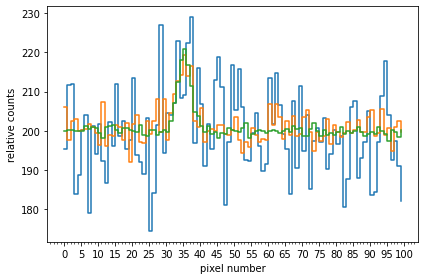

In [58]:
# Plot the coadds of N=[1, 10, and 100] on the same plot:
stack1 = simulateN(x, MU, FWHM, S, F, 1)
stack10 = simulateN(x, MU, FWHM, S, F, 10)
stack100 = simulateN(x, MU, FWHM, S, F, 100)


coadd1 = np.mean(stack1, axis = 0)
coadd10 = np.mean(stack10, axis = 0)
coadd100 = np.mean(stack100, axis = 0)

fig, ax = plt.subplots()
pixel_plot(x, coadd1, fig=fig, ax=ax)
pixel_plot(x, coadd10, fig=fig, ax=ax)
pixel_plot(x, coadd100, fig=fig, ax=ax)

### Problem 1.2)  SNR vs N

Now compute the observed SNR of the simulated star on each coadd and compare to the expected SNR in the idealized case. The often repeated mnemonic for SNR inscrease as a function of number of images, $N$, is that noise decreses like $\sqrt{N}$. This is of course idealized case where the noise in each observation is identical.

Using your `simulateN` function, simulate a series of mean coadds with increasing N.

* First, plot the empirical noise/uncertainty/stdev as a function of N. and overplot the expected uncertainty given the input sky level. You can use an area you know isn't touched by the star. 
* Next, plot the empirical SNR of the star (measured flux/fluxErr) as a function of N. Overplot the expected SNR. You can assume you know the sky level. 

Your expected scaling with N should roughly track your empirical estimate. 

In [36]:
# complete

# hint. One way to start this
std_arr = []
flux_arr = []
flux_err_arr = []
Ns = np.arange(1, 1000, 5)

for N in range(len(Ns)):
    y = simulateN(x, MU, FWHM, S, F, Ns[N])
    std = np.std(y)
    flux = np.sum(y-S)
    flux_err = std/np.sqrt(Ns[N])
    std_arr.append(std)
    flux_arr.append(flux)
    flux_err_arr.append(flux_err)
    
std_arr = np.array(std_arr)
flux_arr = np.array(flux_arr)
flux_err_arr = np.array(flux_err_arr)


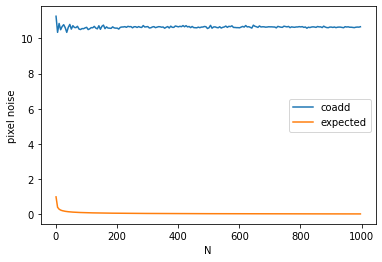

In [41]:
plt.plot(Ns, std_arr,  label="coadd")
plt.plot(Ns, 1/np.sqrt(Ns), label="expected")
plt.xlabel('N')
plt.ylabel('pixel noise')
plt.legend()

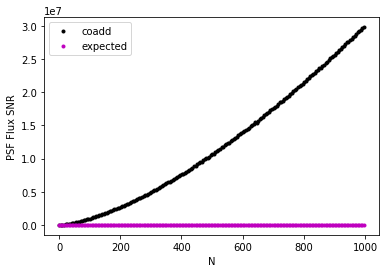

In [81]:
plt.plot(Ns, flux_arr/flux_err_arr, 'k.',  label="coadd")
plt.plot(Ns, Ns, 'm.', label="expected")
plt.xlabel('N')
plt.ylabel('PSF Flux SNR')
plt.legend()

## Problem 2) PSFs and Image weights in coadds 

Problem (1) pretends that the input images are identical in quality, however this is never the case in practice. In practice, adding another image does not necessarily increase the SNR. For example, imagine you have two exposures, but in one the dome light was accidentally left on. A coadd with these two images weighted equally will have a worse SNR than the first image alone. Therefore the images should be aggregated with a weighted mean, so that images of poor quality don't degrade the quality of the coadd. What weights to we pick?

Weights can be chosen to either minimize the variance on the coadd or maximize the SNR of point sources on the coadd. 

#### Some background:

Assuming that all noise sources are independent, the SNR of the measurement of flux from a star is:
\begin{equation}
SNR \propto {{N_{\rm photons}}\over{ \sigma_{\rm sky}} \sqrt{A} },
\end{equation}
where $N_{\rm photons}$ is the number of photons detected from the star,
$A$ is the area in pixels covered by the star.
The per-pixel sky noise  $\sigma_{sky}$ includes all sources of noise: dark current, read noise and sky-background, and it coded in the variance plane of the image. For the epoch $i$,  $\sigma^2_{i, {\rm sky}}$ is the average of the variance plane.

The $N_{\rm photons}$ is proportional to transparency $T$, and the area that the stellar photons cover is determined by the seeing: $A \propto {\rm FWHM}^2$.
 
Therefore, a **coadd optimized for point-source detection** would, to weight each image by the SNR$^2$, use the following as weights which prefers good-seeing epochs taken when the sky is transparent and dark.
\begin{align}
w_i & = {\rm SNR}^2 \propto {{T_i^2}\over{{\rm FWHM_i}^2 \sigma_i^2}}.
\end{align} 
 

The usual inverse-variance weighting which produces the **minimum-variance co-add**, is given by, 
\begin{align}
w_i & =T_i^2/\sigma_i^2
\end{align} 

In practice, the factor of $T_i^2$ is incorporated into the variance when flux-scaling the single-epoch images to a common zeropoint. This step multiplies the image by a scale-factor, which increases the variance of the image by the square of the scale factor. The scale factor is inversely proportional to the transparency, so that
$\sigma_{scaled}= \sigma/T$. 

For this problem assume the images are all on the same zeropoint (like problem 1) i.e. T=1. 

### Problem 2.1  Weighting images in Variable Sky

Now simulate 50 observations of stars with Sky `S` ranging from 100 to 1000. Remember to subtract this background off before stacking this time! Plot the plain (unweighted) mean coadd vs. the minimum variance coadd. Weights should add up to 1. What's the empirical noise estimate of the coadd?

In [74]:
Ss = np.linspace(100, 1000, 50)
N = 50
mean_coadd, variance_coadd = [], []
for s in range(len(Ss)):
    y = simulateN(x, MU, FWHM, Ss[s], F, N)
    y = y - S
    coadd_mean = np.mean(y, axis = 0)
    std = np.std(y, axis = 1)
    weight = 1/(std**2)
    coadd_variance = np.average(y, axis = 0, weights = weight)
    mean_coadd.append(coadd_mean)
    variance_coadd.append(coadd_variance)
variance_coadd = np.array(variance_coadd)
mean_coadd = np.array(mean_coadd)

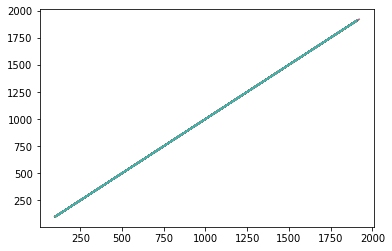

In [75]:
plt.plot(mean_coadd, variance_coadd)

### Problem 2.2  Weighting images in Variable Seeing

Simulate 50 observations with FWHM's ranging from 2-10 pixels. Keep the flux amplitude `F`, and sky noise `S` both fixed. 
Generate two coadds, (1) with the weights that minimize variance and (2) with the weights that maximize point source SNR. Weights should add up to 1. Plot both coadds.

In [78]:
FWHMs = np.linspace(2, 10, 50)
S = 100
mean_coadd, variance_coadd = [], []
for s in range(len(FWHMs)):
    y = simulateN(x, MU, FWHMs[s], S, F, N)
    y = y - S
    coadd_mean = np.mean(y, axis = 0)
    std = np.std(y, axis = 1)
    weight = 1/(std**2)
    coadd_variance = np.average(y, axis = 0, weights = weight)
    mean_coadd.append(coadd_mean)
    variance_coadd.append(coadd_variance)
variance_coadd = np.array(variance_coadd)
mean_coadd = np.array(mean_coadd)

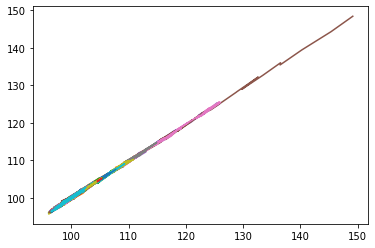

In [79]:
plt.plot(mean_coadd, variance_coadd)

### Problem 2.3 Image variance vs per pixel variance (Challenge Problem)

Why do we use per image variances instead of per pixel variances? Let's see! Start tracking the per-pixel variance when you simulate the star. Make a coadd of 200 observations with FWHM's ranging from 2 to 20 pixels.  Make a coadd weighted by the per-pixel inverse variance. How does the profile of the star look in this coadd compared to an unweighted coadd and compared to the coadd with the $w_i  = \frac{1}{{\rm FWHM_i}^2 \sigma_i^2}$? (You may have to plot the difference to see the change). 

In [ ]:
# complete

## Problem 3) Dipoles in Image Subtraction

In the lesson, we said that just because you see a dipole in a difference image, does not mean that the astrometric registration is terrible. For this problem, we'll forgo the pixelated simulated star from the previous problems and operate with Gaussian profiles. 

In [ ]:
# Create two Gaussian 1-D profiles with

ASTROM_OFFSET = 0.1  # units of e.g. pixels
FLUX_SCALE = 1. # units of e.g nanojansky
PSF = 1  # rms pixels

x = np.linspace(-5, 5)
y1 = FLUX_SCALE * norm.pdf(x, ASTROM_OFFSET, PSF)
y2 = FLUX_SCALE * norm.pdf(x, -ASTROM_OFFSET, PSF)
plt.plot(x, y1, label='profile 1')
plt.plot(x, y2, label='profile 2')
plt.xlabel('x (pixel)')
plt.ylabel('y (flux)')
plt.legend()


### Problem 3.1) Plot the difference of these two profiles:

In [ ]:
# complete

### Problem 3.2)  What if we have amazing astrometric registration
and shrink the astrometric offset by a factor of a thousand. Is there a star sufficiently bright to produce the same dipole? What is its `FLUX SCALE`?

In [ ]:
ASTROM_OFFSET = 0.0001 
PSF = 1. 

# complete 

# Plot both dipoles (for the offset=0.1 and the offset=0.0001 in the same figure.
# Same or different subplots up to you. 

### Problem 3.3) Distance between peaks. 

Does the distance between the dipole's positive and negative peaks depend on the astrometric offset? If not, what *does* it depend on?  You can answer this by vizualizing the dipoles vs offsets. But for a **challenge, measure the distance between peaks** and plot them as a function of astrometric offset or another factor. 

In [ ]:
# complete 

### Problem  3.4) 
In the problem setup we assumed that the astrometric error was < the PSF width. Is this assumption likely to hold in an image you'd get from a wide-field imager like Rubin's?